# CCB模型转债复现

## Data Binding

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.stats import multivariate_normal
import pandas_market_calendars as mcal
import pandas as pd
from visualize import *
from ic_group import *
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
pd.set_option('display.max_columns',None) # avoid omitting columns

In [2]:
# Define the China stock exchange calendar
china_calendar = mcal.get_calendar('XSHG')  # 'XSHG' is the code for the Shanghai Stock Exchange

# Define the date range
start_date = pd.Timestamp('2019-01-01')
end_date = pd.Timestamp('2023-07-04')

# Get the trading days between the specified dates
trading_days = china_calendar.schedule(start_date=start_date, end_date=end_date)

# Extract the trading days as a list
trading_days_list = trading_days.index.strftime('%Y-%m-%d').tolist()

In [3]:
combined_df = pd.DataFrame()
for date in trading_days_list: # Loop over all the trading dates
    #print(date)
    cb_1d = pd.read_csv("E:/data/bond/cross/" + date + '/1d.csv') # daily info of convertible bond
    indicator = pd.read_csv("E:/data/bond/cross/" + date + '/indicator.csv') # derivative indicators
    symbols = pd.read_csv("E:/data/bond/cross/" + date + '/symbols.csv') 
    s_1d = pd.read_csv("E:/data/bond/cross/" + date + '/stock_1d.csv') # daily info of stock

    # rename columns names of s_1d to avoid duplication between factors of convertible bond and respective stock.
    rename_dict = {x:'stock_' + x for x in s_1d.columns}
    rename_dict['order_book_id'] = 'stock_code'
    rename_dict['date'] = 'date' 
    rename_dict
    s_1d = s_1d.rename(columns=rename_dict)

    # merge for a single day
    merged_df = pd.merge(symbols,s_1d,on='stock_code',how='left')
    merged_df = merged_df[['order_book_id', 'value_date', 'maturity_date', 'par_value', 'coupon_rate',
        'coupon_frequency', 'coupon_method', 'compensation_rate',
        'total_issue_size', 'de_listed_date', 'stock_code',
        'conversion_start_date', 'conversion_end_date', 'redemption_price',
        'issue_price', 'call_protection', 'listed_date', 'stop_trading_date',
        'industry_code', 'industry_name', 'stock_open', 'stock_high',
        'stock_low', 'stock_close', 'stock_volume', 'stock_money',
        'stock_num_trades']]
    merged_df = pd.merge(cb_1d,merged_df,on='order_book_id',how='left')
    merged_df = pd.merge(merged_df,indicator,on=('date','order_book_id'),how='left')

    combined_df = combined_df.append(merged_df, ignore_index=True) # Add into the same DataFrame

combined_df['date'] = pd.to_datetime(combined_df['date']) # change the type of date columns
combined_df['conversion_price'] = 100/combined_df['conversion_coefficient'] # conversion price 
combined_df.to_hdf('cb_data.h5',"df", mode='w') # write into h5 file

In [12]:
reread = pd.read_hdf('cb_data.h5') 

In [21]:
# 该函数本用于计算基于历史波动率的BSM价格，此处引用主要为了使用波动率
def BSM_call_historic_vol_y(data,windowlis=[10,20,60,250]):
    """
    BS model using historic yearly volitility
    ------
    Parameter: 
    data(dataframe)
    windowlis(list)
    ------
    Output: 
    data dataframe
    """
    Maturity_Date = data['maturity_date']
    Maturity_Date=Maturity_Date.apply(lambda x:datetime.strptime(x,'%Y-%m-%d'))
    s = data['stock_close']
    x = data['conversion_price']*data['redemption_price']/100.0
    t = (Maturity_Date-data['date']).apply(lambda x: x.days)/365
    data['logreturn_y'] = 250*np.log(data['close']/data['close'].shift())
    for window in windowlis:
        data[f'historic_vol_{window}'] = data['logreturn_y'].rolling(window).var()
        vol = np.sqrt(data[f'historic_vol_{window}'])
        r = 0.02
        d1=(np.log(s/x)+(r+0.5*(vol**2))*t)/(np.sqrt(t)*vol)
        d2=d1-vol*np.sqrt(t)
        ret=s*norm.cdf(d1)-x*np.exp(-r*t)*norm.cdf(d2)
        data[f'call_historic_vol_{window}'] = ret*100/data['conversion_price']
    return data
    
# calculating price from BS model with historic volatility 
df_call_historic_vol_y = reread.groupby('order_book_id').apply(BSM_call_historic_vol_y)

In [23]:
#df_call_historic_vol_y.to_csv('df_call_historic_vol_y.csv')

## CCB Model

In [16]:
def ccb(s,h,rf,tp,tm,fv,vol):
    """
    根据ccb模型，计算的期权部分价值，仅考虑赎回情况
    reference: https://finance.sina.com.cn/stock/stockzmt/2023-03-02/doc-imyinptr4544351.shtml
    input:
    s 平价
    h 赎回(default 130)
    rf 无风险log return(default np.log(1.02))
    tp 赎回保护期
    tm maturity
    fv 最后一期现金流
    """
    return V1(s,h,rf,tp,tm,fv,vol)+V2(s,h,rf,tp,tm,fv,vol)+V3(s,h,rf,tp,tm,fv,vol)

# 由于计算过程冗杂，出现复杂表达式，以下表达式主要用于简化
# K2 = np.log(h/s)
# K1 = np.log(fv/s)    
# u_tu = np.sqrt((rf-vol**2/2)**2+2*vol**2*rf)
# u_hat = rf+vol**2/2
# u = rf-vol**2/2

def V1(s,h,rf,tp,tm,fv,vol): # 赎回保护期内触发赎回的价值
    K2 = np.log(h/s)
    u_hat = rf+vol**2/2
    return s*norm.cdf((-K2+u_hat*tp)/(vol*np.sqrt(tp)))

def V2(s,h,rf,tp,tm,fv,vol): # 赎回保护期外触发赎回的价值
    u = rf-vol**2/2
    K2 = np.log(h/s)
    u_hat = rf+vol**2/2
    u_tu = np.sqrt((rf-vol**2/2)**2+2*vol**2*rf)
    return h*((h/s)**((u-u_tu)/vol**2)*(G(s,h,rf,tm,fv,vol)-G(s,h,rf,tp,fv,vol)+H(s,h,rf,tp,tm,fv,vol)))

def V3(s,h,rf,tp,tm,fv,vol): # 到期行权对应的价值
    K2 = np.log(h/s)
    K1 = np.log(fv/s)  
    u_hat = rf+vol**2/2
    mvn1 = multivariate_normal(mean=np.array([0, 0]),cov=np.array([[1, np.sqrt(tp/tm)], [np.sqrt(tp/tm), 1]]))
    mvn2 = multivariate_normal(mean=np.array([0, 0]),cov=np.array([[1, -np.sqrt(tp/tm)], [-np.sqrt(tp/tm), 1]]))
    point1 = np.array([(K2-u_hat*tp)/(vol*np.sqrt(tp)),(K2-u_hat*tm)/(vol*np.sqrt(tm))])
    point2 = np.array([(K2+u_hat*tp)/(vol*np.sqrt(tp)),(-K2-u_hat*tm)/(vol*np.sqrt(tm))])
    point3 = np.array([(K2-u_hat*tp)/(vol*np.sqrt(tp)),(K1-u_hat*tm)/(vol*np.sqrt(tm))])
    point4 = np.array([(K2+u_hat*tp)/(vol*np.sqrt(tp)),(K1-2*K2-u_hat*tm)/(vol*np.sqrt(tm))])
    E = mvn1.cdf(point1) - np.exp(2*u_hat*np.log(h/s)/vol**2)*mvn2.cdf(point2) - mvn1.cdf(point3) + np.exp(2*u_hat*np.log(h/s)/vol**2)*mvn2.cdf(point4)
    return s * E

def V4(): # 到期不行权对应的价值
    return 0

# G 与 H 用于表达式简化
def G(s,h,rf,t,fv,vol): 
    u_tu = np.sqrt((rf-vol**2/2)**2+2*vol**2*rf)
    return norm.cdf((-np.log(h/s)+t*u_tu)/(vol*np.sqrt(t))) \
        + np.exp(2*u_tu*np.log(h/s)/vol**2) * norm.cdf((-np.log(h/s)-t*u_tu)/(vol*np.sqrt(t)))

def H(s,h,rf,t1,t2,fv,vol):
    u_tu = np.sqrt((rf-vol**2/2)**2+2*vol**2*rf)
    mvn = multivariate_normal(mean=np.array([0, 0]),cov=np.array([[1, -np.sqrt(t1/t2)], [-np.sqrt(t1/t2), 1]]))
    return mvn.cdf(np.array([(-np.log(h/s)+t1*u_tu)/(vol*np.sqrt(t1)), (np.log(h/s)-t2*u_tu)/(vol*np.sqrt(t2))])) \
     + np.exp(2*u_tu*np.log(h/s)/vol**2) * mvn.cdf(np.array([(-np.log(h/s)-t1*u_tu)/(vol*np.sqrt(t1)), (np.log(h/s)+t2*u_tu)/(vol*np.sqrt(t2))])) 
        


In [3]:
df_call_historic_vol_y = pd.read_csv('df_call_historic_vol_y.csv')
pd.set_option('display.max_columns',None)

In [8]:
# tm计算
df_call_historic_vol_y['time_to_maturity'] = (df_call_historic_vol_y['maturity_date'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d')) \
                                        - df_call_historic_vol_y['date'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d'))).apply(lambda x: x.days)/365
# tp计算 （为避免tp取0，没有赎回保护期与过了赎回保护期情况，tp取0.0001）
df_call_historic_vol_y['call_protection'].fillna(0,inplace=True)
df_call_historic_vol_y['time_to_protection'] = ((df_call_historic_vol_y['value_date'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d'))+ df_call_historic_vol_y['call_protection'].apply(lambda x: relativedelta(months=x)) \
                                        - df_call_historic_vol_y['date'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d'))).apply(lambda x: x.days)/365).apply(lambda x: x if x>0 else 0.0001)

In [9]:
# vol转换 将0，nan转为0.0001
df_call_historic_vol_y['non_zero_vol'] = df_call_historic_vol_y['historic_vol_20'].apply(lambda x: x if x else 0.0001)

In [8]:
df_call_historic_vol_y

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,date,order_book_id,open,high,low,close,volume,money,num_trades,value_date,maturity_date,par_value,coupon_rate,coupon_frequency,coupon_method,compensation_rate,total_issue_size,de_listed_date,stock_code,conversion_start_date,conversion_end_date,redemption_price,issue_price,call_protection,listed_date,stop_trading_date,industry_code,industry_name,stock_open,stock_high,stock_low,stock_close,stock_volume,stock_money,stock_num_trades,pure_bond_value_1,yield_to_maturity_pretax,pure_bond_value_pretax,yield_to_put,conversion_premium,pure_bond_value,put_trigger_price,conversion_value,pure_bond_value_premium_pretax,convertible_market_cap_ratio,call_status,conversion_price_reset_status,yield_to_put_pretax,remaining_size,call_qualified_days,conversion_coefficient,call_trigger_price,turnover_rate,conversion_price_reset_qualified_days,pure_bond_value_premium,conversion_price_reset_trigger_price,yield_to_maturity,put_status,put_qualified_days,pb_ratio,pure_bond_value_premium_1,double_low_factor,CURYIELD,YTM_CB,STRBPREMIUMRATIO,CONVPREMIUMRATIO,CONVPE,CONVPB,UNDERLYINGPE,UNDERLYINGPB,DILUTERATE,LDILUTERATE,IMPLIEDVOL,conversion_price,logreturn_y,historic_vol_10,call_historic_vol_10,historic_vol_20,call_historic_vol_20,historic_vol_60,call_historic_vol_60,historic_vol_250,call_historic_vol_250,time_to_maturity,time_to_protection,non_zero_vol,ccb_option,price_diff
0,0,0,0,2019-01-02,113011.XSHG,105.000,105.470,103.400,103.780,823250.0,8.566986e+07,0.0,2017-03-17,2023-03-17,100.0,0.002,1,stepup_rate,NaN,3.000000e+10,2023-03-17,601818.XSHG,2017-09-18,2023-03-16,105.0,100.0,6.0,2017-04-05,NaN,40,银行,3.1494,3.1665,3.0897,3.1153,51061307.0,1.867696e+08,13154.0,93.487662,0.013798,93.483933,NaN,0.174278,91.748668,NaN,88.377724,0.110137,0.156584,1.0,0.0,NaN,2.999927e+10,0.0,24.213075,5.369,0.002752,3.0,0.131134,3.3040,0.009331,0.0,0.0,0.488164,0.110093,121.207781,0.4818,1.3798,11.0285,17.4278,8.5722,0.7908,5.656171,0.595935,12.156284,15.430393,17.370619,4.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.205479,0.000100,NaN,NaN,NaN
1,1,1,1,2019-01-02,110030.XSHG,102.260,102.350,102.250,102.320,18810.0,1.924131e+06,0.0,2014-12-25,2019-12-25,100.0,0.006,1,stepup_rate,NaN,9.800000e+08,2019-12-25,600185.XSHG,2015-06-30,2019-12-24,106.0,100.0,6.0,2015-01-13,2019-12-11,42,房地产,4.0600,4.0900,3.9800,4.0600,11824389.0,4.782800e+07,2887.0,101.978148,0.036772,101.978148,-0.019426,0.749017,100.823678,4.858,58.501441,0.003352,0.050817,1.0,1.0,-0.018470,4.250350e+08,0.0,14.409222,9.022,0.004424,20.0,0.014841,6.2460,0.024781,2.0,30.0,2.769657,0.003352,177.221675,1.9547,3.6786,0.4853,74.9018,37.3737,1.9525,13.988674,1.020551,2.886960,2.886960,32.696221,6.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.978082,0.000100,NaN,NaN,NaN
2,2,2,2,2019-01-02,113510.XSHG,93.100,93.400,93.010,93.030,1920.0,1.791770e+05,0.0,2018-06-19,2024-06-19,100.0,0.004,1,stepup_rate,NaN,1.140000e+08,2020-03-25,603601.XSHG,2018-12-25,2024-06-18,108.0,100.0,6.0,2018-07-13,2020-03-25,22,基础化工,5.6406,5.6849,5.2562,5.3079,3006612.7,1.698365e+07,3127.0,78.257986,0.037537,78.374707,0.050501,0.466713,76.413048,9.056,63.427562,0.186990,0.029352,1.0,1.0,0.052046,1.139323e+08,0.0,8.833922,14.716,0.001690,20.0,0.217462,9.6220,0.032807,0.0,0.0,6.015822,0.188760,139.701253,0.4300,3.7517,19.7784,46.6712,46.9924,4.5275,25.125248,2.924571,1.827655,1.827655,39.494031,11.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.465753,0.000100,NaN,NaN,NaN
3,3,3,3,2019-01-02,128042.XSHE,94.600,94.986,94.380,94.748,12151.0,1.149000e+06,97.0,2018-07-30,2024-07-30,100.0,0.004,1,stepup_rate,NaN,4.160000e+08,2024-07-30,002823.XSHE,2019-02-11,2024-07-29,112.0,100.0,6.0,2018-09-03,NaN,26,机械,9.9033,9.9895,9.7978,9.8457,699376.0,7.200595e+06,779.0,89.217188,0.039822,89.188501,0.022791,0.222406,86.462933,9.275,77.509434,0.062334,0.139047,0.0,1.0,0.024886,4.160000e+08,0.0,7.547170,17.225,0.002915,30.0,0.095822,11.2625,0.034016,0.0,0.0,2.265898,0.061993,116.988604,0.4222,3.9822,6.5473,22.2407,29.1956,2.7909,18.428259,2.270

In [11]:
df_call_historic_vol_y.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'date', 'order_book_id', 'open', 'high',
       'low', 'close', 'volume', 'money', 'num_trades', 'value_date',
       'maturity_date', 'par_value', 'coupon_rate', 'coupon_frequency',
       'coupon_method', 'compensation_rate', 'total_issue_size',
       'de_listed_date', 'stock_code', 'conversion_start_date',
       'conversion_end_date', 'redemption_price', 'issue_price',
       'call_protection', 'listed_date', 'stop_trading_date', 'industry_code',
       'industry_name', 'stock_open', 'stock_high', 'stock_low', 'stock_close',
       'stock_volume', 'stock_money', 'stock_num_trades', 'pure_bond_value_1',
       'yield_to_maturity_pretax', 'pure_bond_value_pretax', 'yield_to_put',
       'conversion_premium', 'pure_bond_value', 'put_trigger_price',
       'conversion_value', 'pure_bond_value_premium_pretax',
       'convertible_market_cap_ratio', 'call_status',
       'conversion_price_reset_status', 'yield_to_put_pretax',
       'remaining_size',

In [12]:
# ccb option price calculation 
df_call_historic_vol_y['ccb_option'] = df_call_historic_vol_y.apply(lambda row: ccb(row['conversion_value'], 130, np.log(1.02),row['time_to_protection'],row['time_to_maturity'], row['redemption_price'],row['non_zero_vol']), axis=1)


In [2]:
df_call_historic_vol_y.to_csv('df_call_historic_vol_y.csv')

NameError: name 'df_call_historic_vol_y' is not defined

## Some Graphs

In [13]:
def plot_comparison(df_i,order_book_id,mode):
    """
    Show the plot of close price and theoretically predicted price.
    The volitility is also shown in the plot.
    ------
    Parameter:
    df_i(dataframe): the dataframe with the price of one mode.
    order_book_id(str)
    mode(str): chosen from 'BSM_rq_iv', 'BSM_nt_iv', 'BSM_his_vol'
    ------
    Output:
    Line plot
    """
    if mode == 'BSM_rq_iv':
        call_name='call_rq_iv'
        vol_name='IMPLIEDVOL'
    elif mode == 'BSM_nt_iv':
        call_name='call_nt_iv'
        vol_name='IV_ConvBond'
    elif mode == 'ccb':
        call_name='ccb_option'
        vol_name='non_zero_vol'
    else: # BSM_his_vol
        winlen = mode.split("_")[-1]
        call_name=f'call_historic_vol_{winlen}'
        vol_name=f'historic_vol_{winlen}'

    x = df_i['date']
    y1 = (df_i[call_name]+df_i['pure_bond_value_1']).shift(-1)
    y2 = df_i[vol_name]
    y3 = df_i['close']
    fig, ax1 = plt.subplots()

    # Plot the first dataset
    ax1.plot(x, y1, 'b-', label='BSM')
    ax1.plot(x, y3, 'r', label='close')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price', color='b')
    ax1.tick_params('y', colors='b')

    # Create the second subplot
    ax2 = ax1.twinx()

    # Plot the second dataset
    ax2.plot(x, y2, 'g', label='vol')
    ax2.set_ylabel('VOL', color='r')
    ax2.tick_params('y', colors='r')

    # Add a legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')
    plt.title(order_book_id)
    # Display the plot
    plt.show()

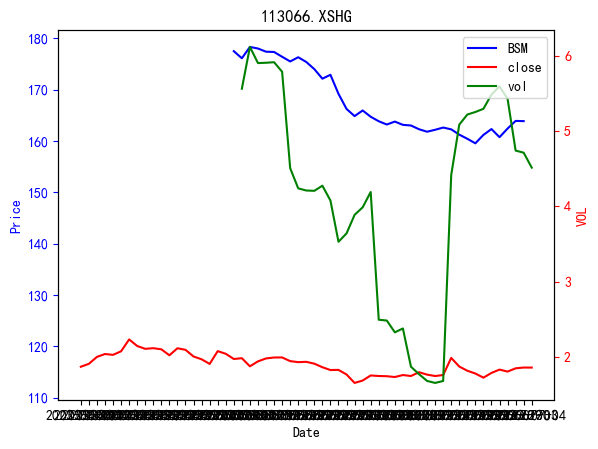

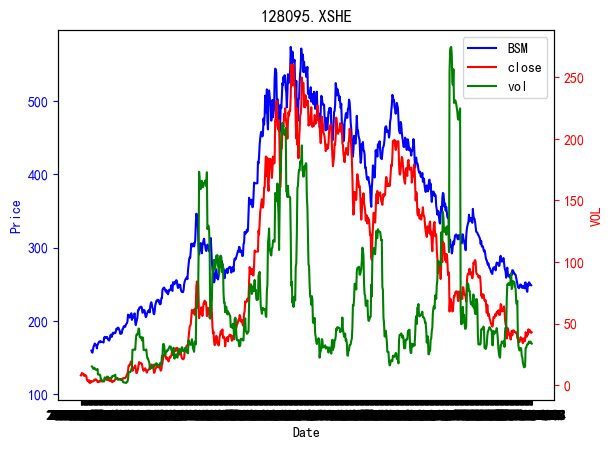

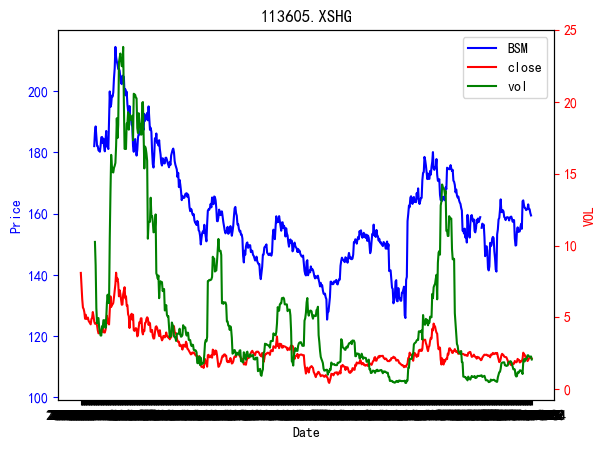

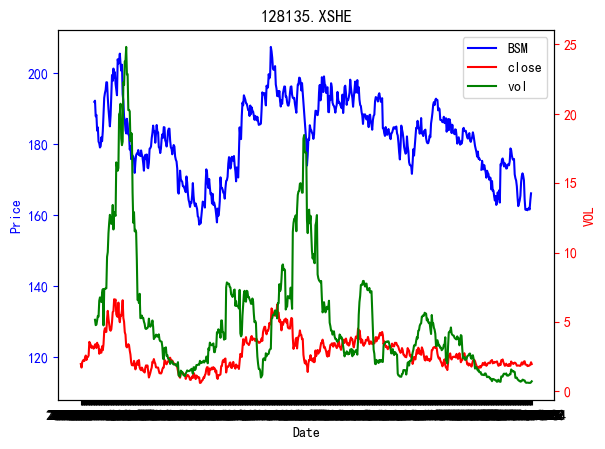

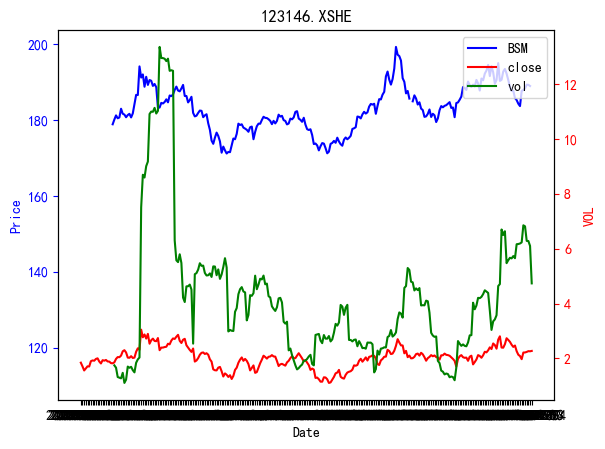

In [14]:
order_book_id_lis = list(set(df_call_historic_vol_y['order_book_id']))
# plot of some examples
for i in range(0,5):
    order_book_id = order_book_id_lis[i]
    df_i = df_call_historic_vol_y[df_call_historic_vol_y['order_book_id']==order_book_id]
    #mpl.rcParams['font.family'] = 'Times New Roman'
    plot_comparison(df_i,order_book_id,'ccb')

## Price_Diff Factor Analysis

<Figure size 1500x1200 with 0 Axes>

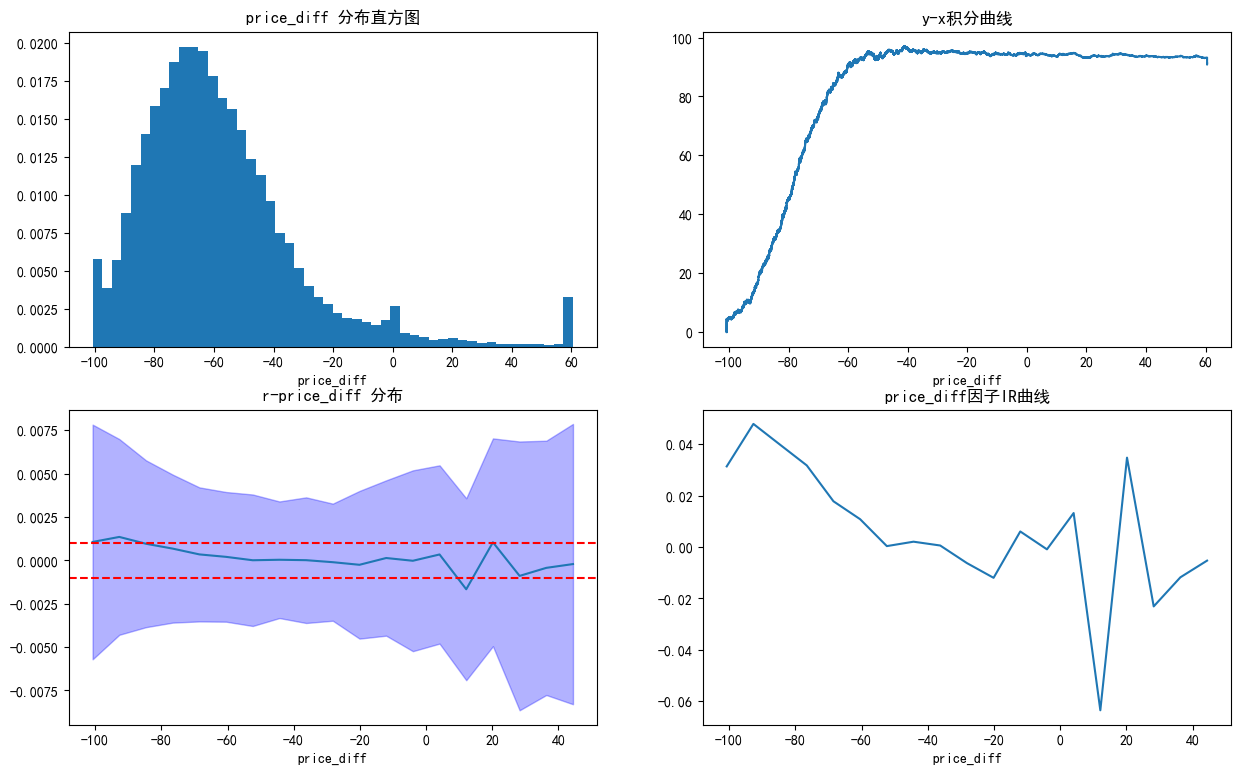

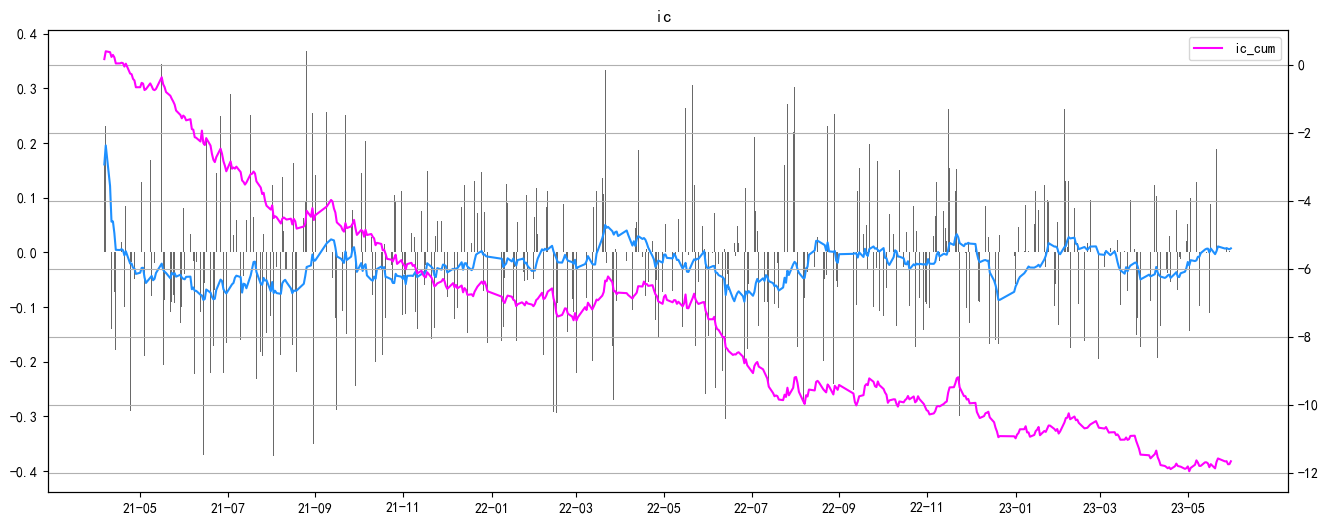

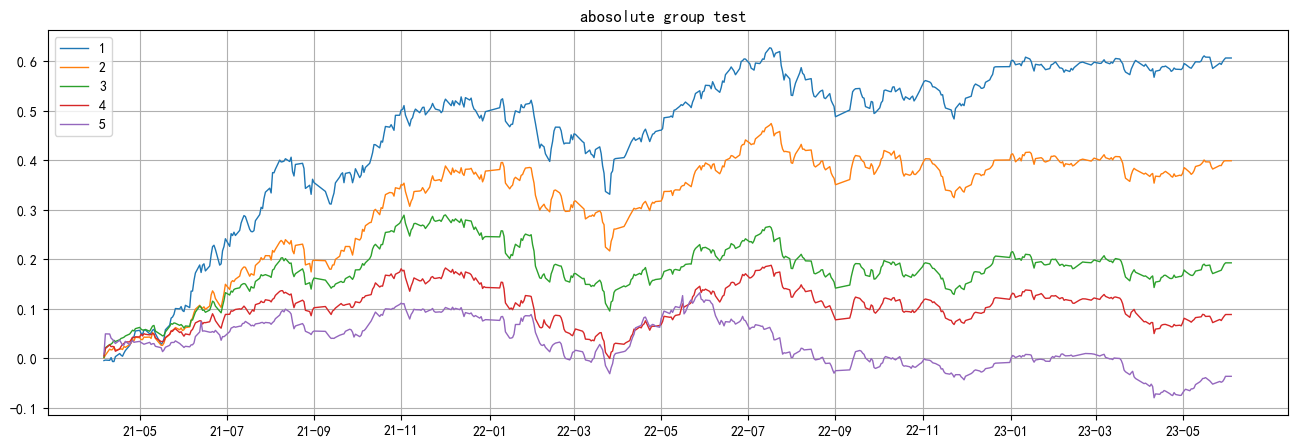

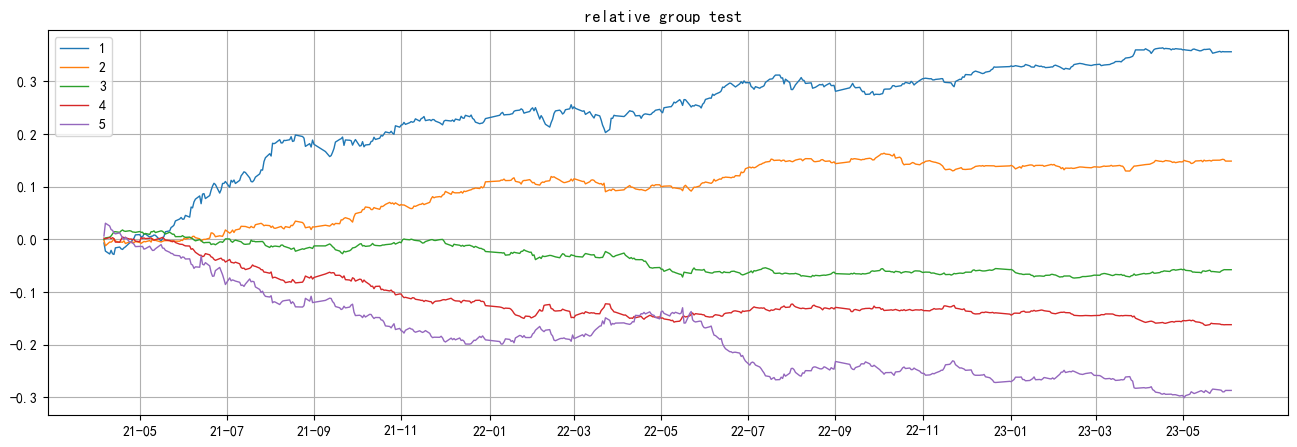

In [6]:
from visualize import *
from ic_group import *
#mpl.rcParams['font.family'] = 'Times New Roman'

df_call_historic_vol_y['price_diff'] = df_call_historic_vol_y['close'] - df_call_historic_vol_y['ccb_option'] - df_call_historic_vol_y['pure_bond_value_1']
df = df_call_historic_vol_y
df = df.sort_values(['order_book_id','date'])
data = df
# 构建因子 
# df['factor1'] = np.where(df.order_book_id == df.order_book_id.shift(20),df.close/df.close.shift(20)-1,np.nan)
factor = 'price_diff'

# 预测收益
df['r'] = np.where(df.order_book_id == df.order_book_id.shift(-2),df.open.shift(-2)/df.open.shift(-1)-1,0)
r= 'r'
df['price_pred']=df['ccb_option']+df['pure_bond_value_1']
df['factor1']=df['price_pred']/df['close']-1
df['new_price']=df['price_pred']*(df['close'].shift(1)/df['price_pred'].shift(2)\
                            +df['close'].shift(3)/df['price_pred'].shift(4)\
                            +df['close'].shift(5)/df['price_pred'].shift(6)\
                            +df['close'].shift(6)/df['price_pred'].shift(8)\
                            +df['close'].shift(8)/df['price_pred'].shift(10))/5
df['factor2']=np.where(df.order_book_id==df.order_book_id.shift(10),df['new_price']/df['close']-1,0)
factor ='price_diff'
factor1='factor1'
factor2='factor2'
data = df[['date','order_book_id','r',factor1,factor2,factor]].dropna()
data = data[~np.isinf(data['r'])]
data = data[data['date']>'2021-05-01']
data['date'] = data['date'].apply(lambda x:str(x)[:10])
look(data,factor,r,thresh=0.01, div_num=20)
analyse_ic(data,factor,r)    
analyse_group_new(data,factor,r,is_alpha=False,num_group=5)
analyse_group_new(data,factor,r,is_alpha=True,num_group=5)

In [16]:
df_call_historic_vol_y.to_csv('df_call_historic_vol_y.csv')

<Figure size 1500x1200 with 0 Axes>

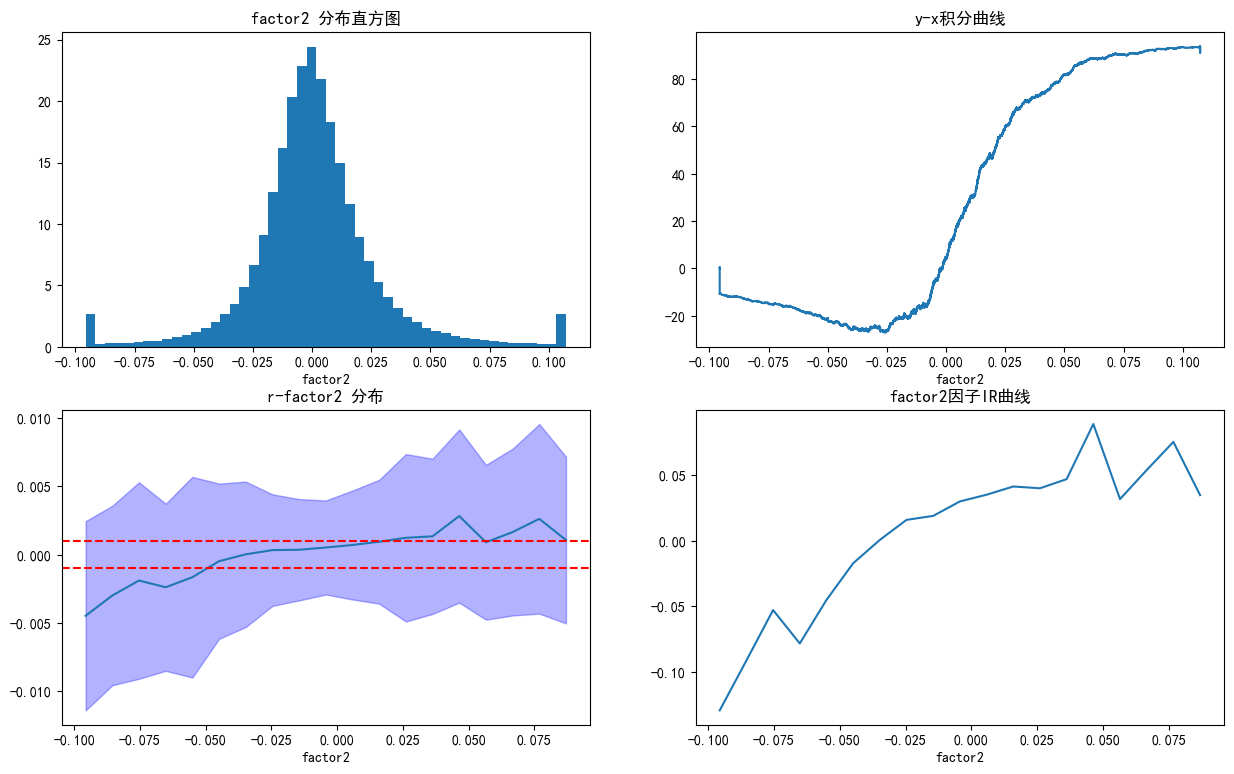

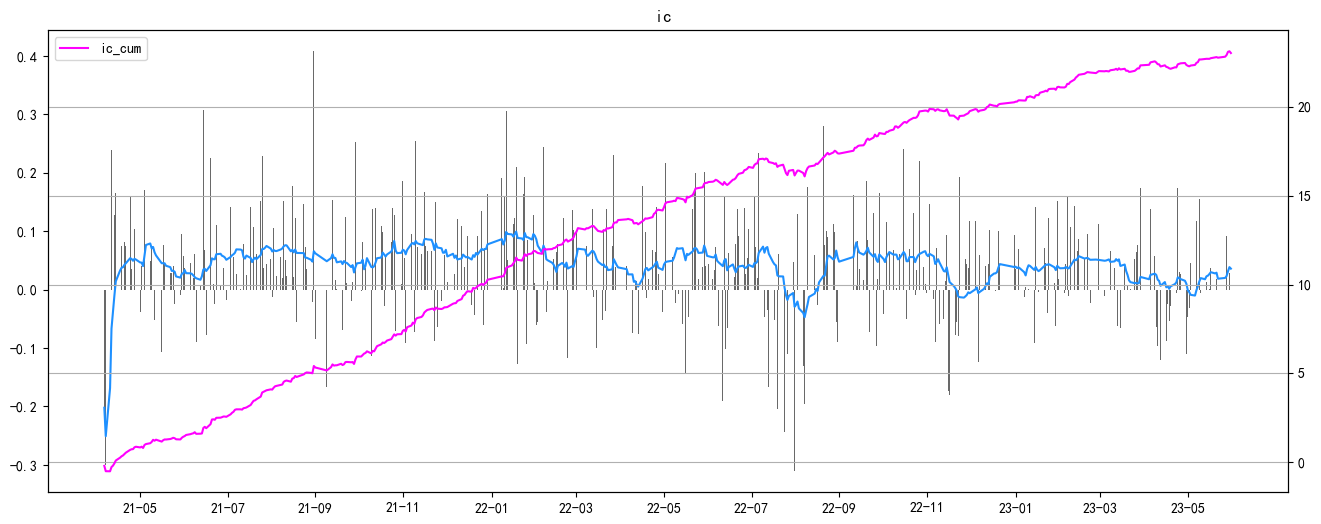

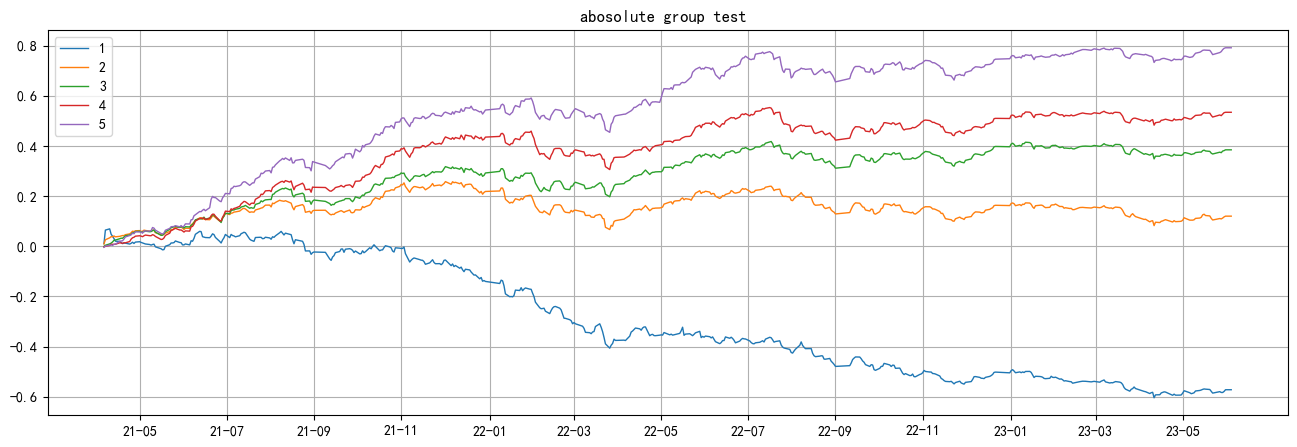

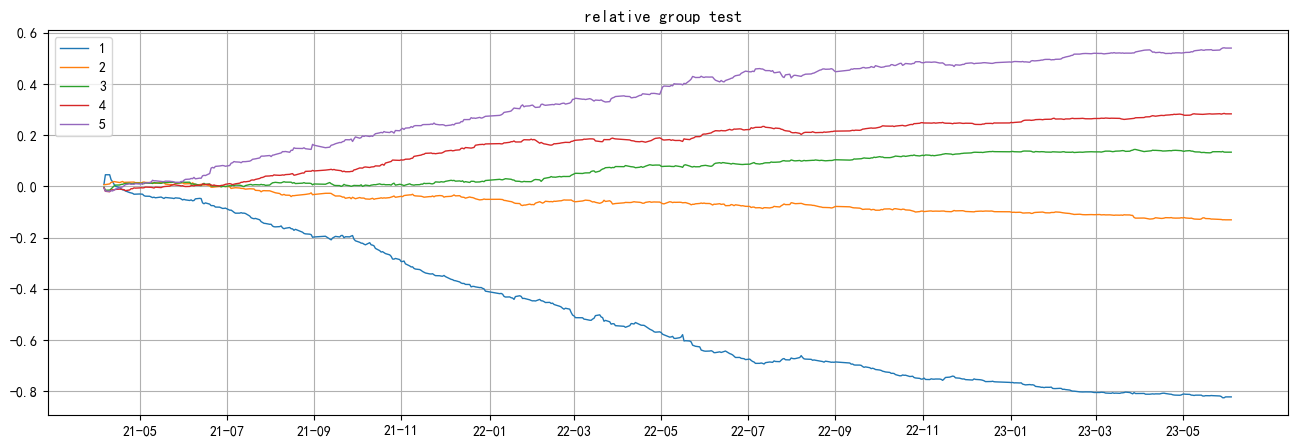

In [7]:
look(data,factor2,r,thresh=0.01, div_num=20)
analyse_ic(data,factor2,r)    
analyse_group_new(data,factor2,r,is_alpha=False,num_group=5)
analyse_group_new(data,factor2,r,is_alpha=True,num_group=5)